# Phase Estimation of molecular ground state energy using Qiskit

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
#from iqx import *

from qiskit.aqua.circuits import PhaseEstimationCircuit
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.core import Hamiltonian
from qiskit.circuit.library import PhaseEstimation
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.quantum_info import Statevector

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


The aim of this notebook is to explain how to use Quantum Phase Estimation to get an approximation of the energy of a molecule, in this case $H_2$. We start loading the information as we did in the VQE tutorial.

In [2]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule, PSI4Driver
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
qmol = driver.run()

print(qmol.one_body_integrals)
print(qmol.two_body_integrals)

[[-1.25633907  0.          0.          0.        ]
 [ 0.         -0.47189601  0.          0.        ]
 [ 0.          0.         -1.25633907  0.        ]
 [ 0.          0.          0.         -0.47189601]]
[[[[-0.33785508  0.          0.          0.        ]
   [ 0.         -0.0904656   0.          0.        ]
   [ 0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.        ]]

  [[ 0.         -0.0904656   0.          0.        ]
   [-0.33229087  0.          0.          0.        ]
   [ 0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.        ]]

  [[ 0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.        ]
   [-0.33785508  0.          0.          0.        ]
   [ 0.         -0.0904656   0.          0.        ]]

  [[ 0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.        ]
   [ 0.         -0.0904656   0.          0.    

The previous one and two body integrals are important because in order to apply Phase Estimation we need to make sure the eigenvalues are between 0 and 1. This will mean we will apply $1/2$ of the operator. Also from the VQE tutorial

In [3]:
from qiskit.chemistry.transformations import (FermionicTransformation, 
                                              FermionicTransformationType, 
                                              FermionicQubitMappingType)

fermionic_transformation = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER,
            two_qubit_reduction=False,
            freeze_core=False)

Define the initial state

Qubit operator is SummedOp([
  -0.8105479805373264 * IIII,
  0.17218393261915527 * IIIZ,
  -0.22575349222402502 * IIZI,
  0.17218393261915532 * IZII,
  -0.22575349222402497 * ZIII,
  0.12091263261776641 * IIZZ,
  0.16892753870087926 * IZIZ,
  0.04523279994605789 * XXYY,
  0.04523279994605789 * YYYY,
  0.04523279994605789 * XXXX,
  0.04523279994605789 * YYXX,
  0.1661454325638243 * ZIIZ,
  0.1661454325638243 * IZZI,
  0.17464343068300467 * ZIZI,
  0.12091263261776641 * ZZII
])
[False  True False  True]


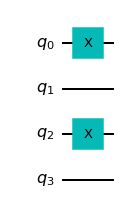

In [4]:
qubit_op, _ = fermionic_transformation.transform(driver)
print('Qubit operator is', qubit_op)

num_orbitals = fermionic_transformation.molecule_info['num_orbitals']
num_particles = fermionic_transformation.molecule_info['num_particles']
qubit_mapping = fermionic_transformation.qubit_mapping
two_qubit_reduction = fermionic_transformation.molecule_info['two_qubit_reduction']
z2_symmetries = fermionic_transformation.molecule_info['z2_symmetries']

initial_state = HartreeFock(num_orbitals, num_particles, qubit_mapping,
                            two_qubit_reduction, z2_symmetries.sq_list)

initial_circ = initial_state.construct_circuit()

print(initial_state.bitstr)

initial_circ.draw()

In [5]:
qubit_op, _ = fermionic_transformation.transform(driver)
print(qubit_op)

num_evaluation_qubits = 5
normalization_factor = 1/2 # Since the min energy will be -1.8... we need to normalize it so that it is smaller than 1
unitary = (normalization_factor*qubit_op).exp_i().to_circuit()
phase_estimation = PhaseEstimation(num_evaluation_qubits = num_evaluation_qubits, unitary = unitary)

SummedOp([
  -0.8105479805373264 * IIII,
  0.17218393261915527 * IIIZ,
  -0.22575349222402502 * IIZI,
  0.17218393261915532 * IZII,
  -0.22575349222402497 * ZIII,
  0.12091263261776641 * IIZZ,
  0.16892753870087926 * IZIZ,
  0.04523279994605789 * XXYY,
  0.04523279994605789 * YYYY,
  0.04523279994605789 * XXXX,
  0.04523279994605789 * YYXX,
  0.1661454325638243 * ZIIZ,
  0.1661454325638243 * IZZI,
  0.17464343068300467 * ZIZI,
  0.12091263261776641 * ZZII
])


In [6]:
type(qubit_op.exp_i().to_circuit())

qiskit.circuit.quantumcircuit.QuantumCircuit

We can plot the Phase Estimation circuit

[Qubit(QuantumRegister(5, 'eval'), 0), Qubit(QuantumRegister(5, 'eval'), 1), Qubit(QuantumRegister(5, 'eval'), 2), Qubit(QuantumRegister(5, 'eval'), 3), Qubit(QuantumRegister(5, 'eval'), 4), Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)]


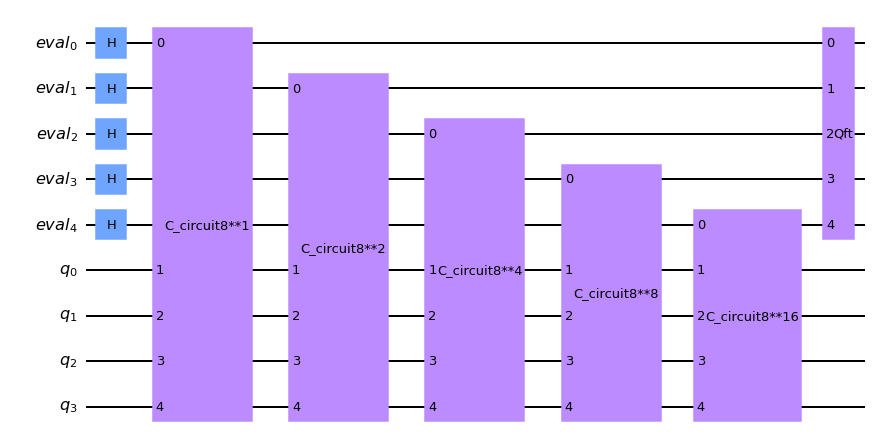

In [7]:
print(phase_estimation.qubits)
dir(phase_estimation)
phase_estimation.draw()

And combining it with the state preparation

[QuantumRegister(4, 'q'), QuantumRegister(5, 'eval')]


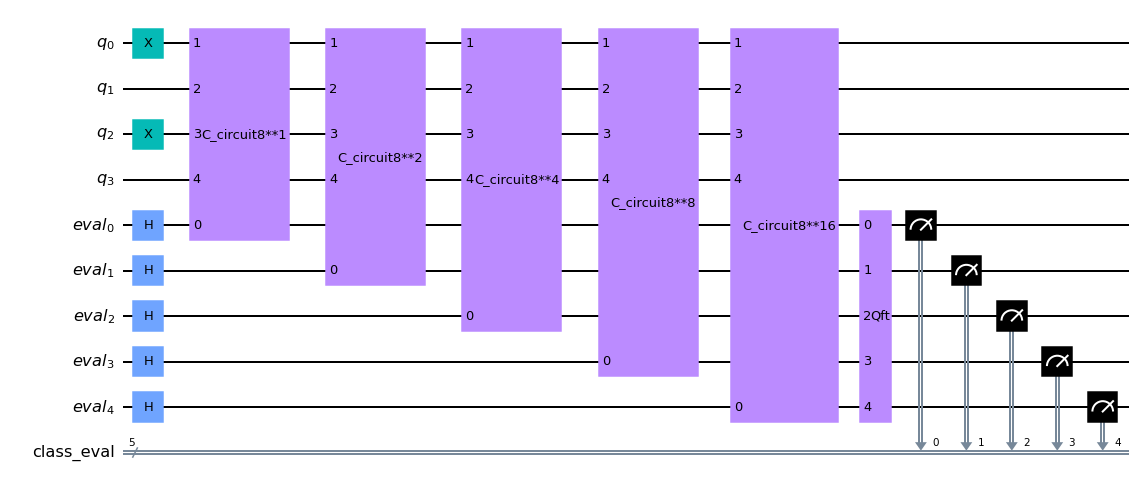

In [8]:
circ = initial_circ.combine(phase_estimation)
classical_eval = ClassicalRegister(num_evaluation_qubits, name = 'class_eval')
circ = circ + QuantumCircuit(classical_eval)
#circ.measure_all()
print(circ.qregs)
circ.measure(circ.qregs[1], classical_eval)
circ.draw()

Let us run the experiment and see what we get!

experiment = execute(circ, backend = Aer.get_backend('statevector_simulator'))
state_vector = Statevector(experiment.result().get_statevector(circ))
probabilities = state_vector.probabilities()
print(probabilities)

In [9]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(circ, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(circ)
print(counts)

{'00001': 38, '10000': 2, '10001': 13, '10010': 2, '10101': 2, '10110': 19, '10111': 1, '11001': 3, '11010': 9, '11011': 1, '11100': 3, '11110': 778, '00010': 1, '00011': 1, '00100': 1, '00101': 3, '00110': 10, '00111': 2, '01000': 1, '01001': 4, '01010': 10, '01100': 1, '01101': 1, '01110': 117, '01111': 1}


It is very important to notice that the resulting bits are reversed! $\phi_4, \phi_3, \phi_2, \phi_1, \phi_0$. The energy then is the normalization constant (2 in this case) times $\sum_i \phi_i/2^i$. There is a minus sign because the op.exp_i() will apply $e^{-i\times op}$. The energy, in Hartrees, in this case is:

In [10]:
maxkey = '0'*num_evaluation_qubits
maxvalue = 0
for key, value in counts.items():
    if value > maxvalue:
        maxvalue = value
        maxkey = key

energy = 0
for i,s in zip(range(num_evaluation_qubits), maxkey[::-1]):
    energy -= (int(s)/2**(i))/normalization_factor
    
print('The energy is', energy, 'Hartrees')

The energy is -1.875 Hartrees


which is by the way pretty close to the value of $-1.857$ Hartrees calculated in the VQE section.

In [11]:
36/32

1.125

In [12]:
26/16

1.625